# House Prices: Complete Beginner-Friendly End-to-End Notebook 
 
**Goal:**   
Predict the house sale price (`SalePrice`) for each row in `test.csv`. 
 
**Competition metric:**   
Root Mean Squared Error (RMSE) between `log(SalePrice)` of predictions and `log(SalePrice)` of the true values. 
 
**Steps in this notebook:** 
 
1. Load libraries and data   
2. Explore the data (visual EDA)   
3. Prepare the data (handle missing values, encode categories)   
4. Build two models: 
   - Ridge Regression (linear) 
   - Random Forest Regressor (tree-based) 
5. Evaluate both with cross-validation   
6. Hyperparameter tuning (GridSearchCV) for both models   
7. Compare tuned models   
8. Train tuned models on full data and make predictions   
9. Create submission files for Kaggle   
 
This notebook is written for beginners, with short explanations and clear comments. 

In [1]:
!pip install -q -U "scikit-learn==1.4.2" "scipy==1.11.4"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 115.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 54.8 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.11.4 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.4.2 which is incompatible.


In [2]:
# ==========================
# 1. Imports & Basic Settings
# ==========================

import numpy as np
import pandas as pd


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# Machine learning tools
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge

# Models
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor


In [3]:
# Compatibility patch: make scipy.sparse.linalg.cg accept 'tol' for older scikit-learn Ridge
import scipy.sparse.linalg as sla
_orig_cg = sla.cg
def _cg_compat(A, b, x0=None, maxiter=None, tol=None, **kwargs):
    # Map legacy 'tol' argument to SciPy's 'rtol' when not provided
    if tol is not None and "rtol" not in kwargs and "atol" not in kwargs:
        kwargs["rtol"] = tol
    return _orig_cg(A, b, x0=x0, maxiter=maxiter, **kwargs)
sla.cg = _cg_compat


In [4]:
# ================== 
# 2. Load the Data 
# ================== 
 
# Make sure train.csv and test.csv are in the same folder as this notebook 
train_df = pd.read_csv("/kaggle/input/house-prices-dataset/train.csv") 
test_df = pd.read_csv("/kaggle/input/house-prices-dataset/test.csv") 
 
# Look at the first few rows 
train_df.head() 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# Check shapes of train and test data 
print("Train shape:", train_df.shape) 
print("Test shape:", test_df.shape) 

Train shape: (1460, 81)
Test shape: (1459, 80)


In [6]:
# ========================= 
# 3. Quick Data Overview 
# ========================= 
 
# Info about columns, types, and missing values 
train_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
# Summary statistics for numeric columns (first 15 rows for readability) 
train_df.describe().T.head(15) 

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


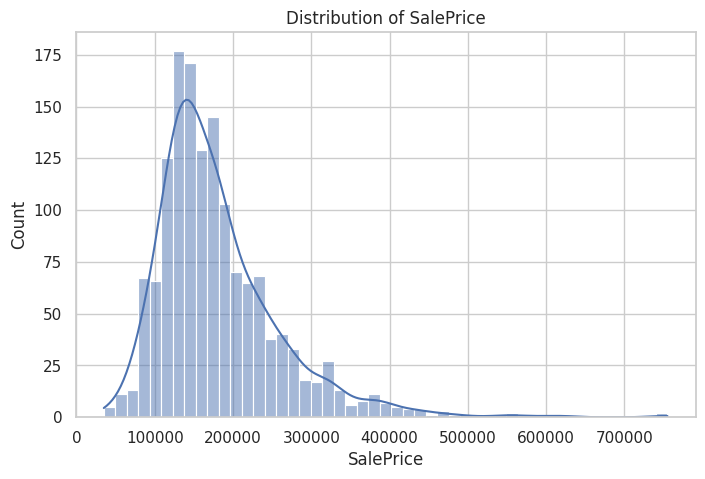

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


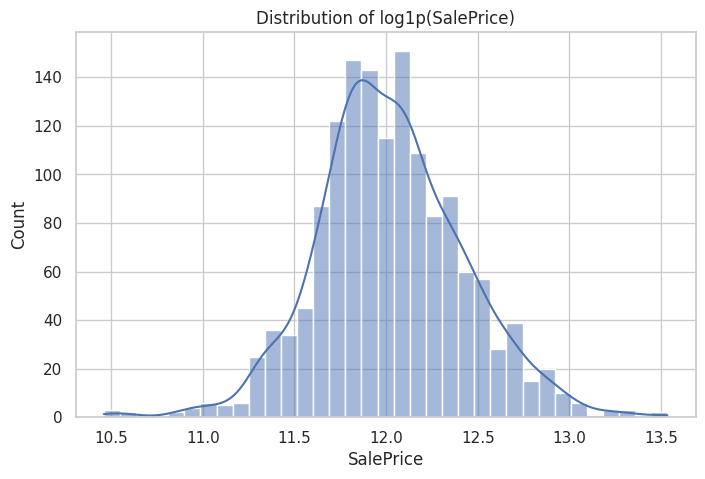

In [8]:
# ========================== 
# 4. Visual EDA - Target 
# ========================== 
 
# Distribution of SalePrice (original scale) 
sns.histplot(train_df["SalePrice"], kde=True) 
plt.title("Distribution of SalePrice") 
plt.show() 
 
# Distribution of log1p(SalePrice) 
log_saleprice = np.log1p(train_df["SalePrice"]) 
sns.histplot(log_saleprice, kde=True) 
plt.title("Distribution of log1p(SalePrice)") 
plt.show() 
 
# Note: log1p(x) = log(1 + x). This makes large and small prices more comparable. 

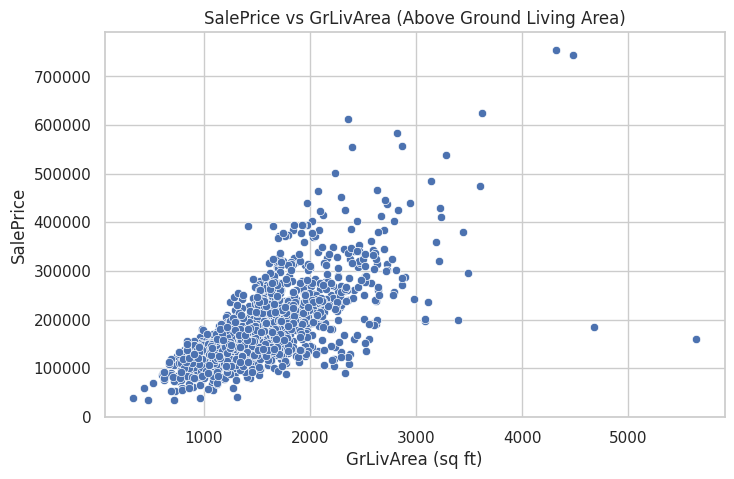

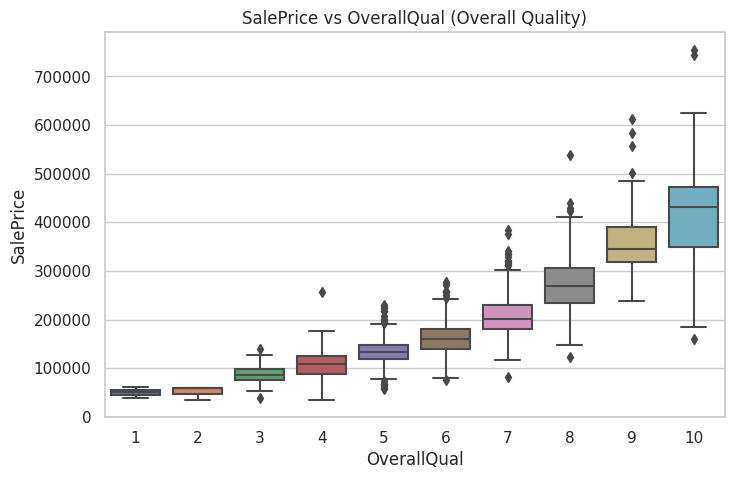

In [9]:
# ========================================== 
# 5. Visual EDA - Relationships (Examples) 
# ========================================== 
 
# Scatter: GrLivArea vs SalePrice 
sns.scatterplot(x=train_df["GrLivArea"], y=train_df["SalePrice"]) 
plt.title("SalePrice vs GrLivArea (Above Ground Living Area)") 
plt.xlabel("GrLivArea (sq ft)") 
plt.ylabel("SalePrice") 
plt.show() 
 
# Boxplot: OverallQual vs SalePrice 
sns.boxplot(x=train_df["OverallQual"], y=train_df["SalePrice"]) 
plt.title("SalePrice vs OverallQual (Overall Quality)") 
plt.xlabel("OverallQual") 
plt.ylabel("SalePrice") 
plt.show() 

In [10]:
# =============================== 
# 6. Missing Values Overview 
# =============================== 
 
# Count missing values per column 
missing_counts = train_df.isnull().sum() 
 
# Keep only columns with at least 1 missing value 
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False) 
 
# Show top 20 columns with missing values 
missing_counts.head(20) 

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

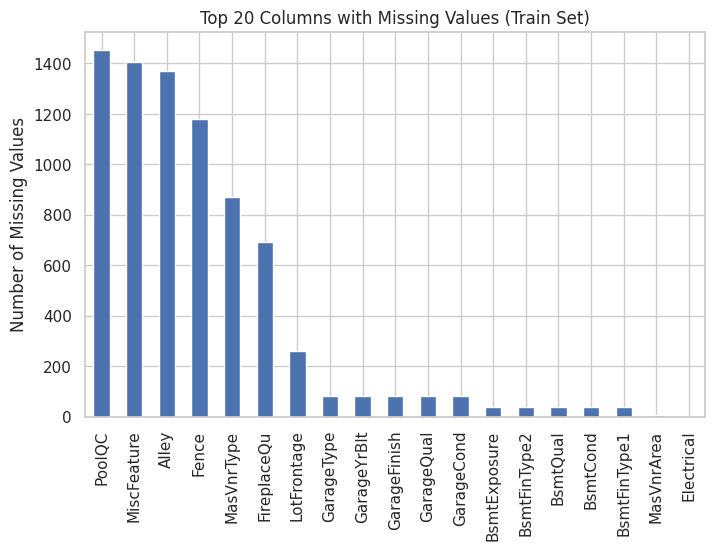

In [11]:
# Plot top 20 columns with missing values 
missing_counts.head(20).plot(kind="bar") 
plt.title("Top 20 Columns with Missing Values (Train Set)") 
plt.ylabel("Number of Missing Values") 
plt.show() 

In [12]:
# ====================================== 
# 7. Correlation with SalePrice (Numeric) 
# ====================================== 
 
# Select numeric columns 
numeric_cols = train_df.select_dtypes(include=["int64", "float64"]) 
 
# Correlation of each numeric feature with SalePrice 
corr_with_target = numeric_cols.corr()["SalePrice"].sort_values(ascending=False) 
 
# Show top 15 most correlated features 
corr_with_target.head(15) 

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64

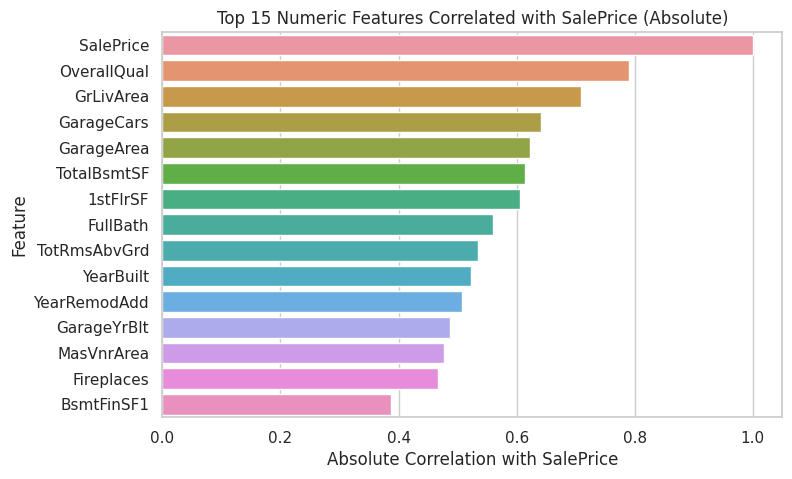

In [13]:
# Plot top 15 features by absolute correlation with SalePrice 
top_corr = corr_with_target.abs().sort_values(ascending=False).head(15) 
 
sns.barplot(x=top_corr.values, y=top_corr.index) 
plt.title("Top 15 Numeric Features Correlated with SalePrice (Absolute)") 
plt.xlabel("Absolute Correlation with SalePrice") 
plt.ylabel("Feature") 
plt.show() 

In [14]:
# ===================================== 
# 8. Example Categorical Feature: Neighborhood 
# ===================================== 
 
# Median SalePrice by Neighborhood 
neigh_median = train_df.groupby("Neighborhood")["SalePrice"].median().sort_values(ascending=False) 
 
# Show top 10 neighborhoods 
neigh_median.head(10) 

Neighborhood
NridgHt    315000.0
NoRidge    301500.0
StoneBr    278000.0
Timber     228475.0
Somerst    225500.0
Veenker    218000.0
Crawfor    200624.0
ClearCr    200250.0
CollgCr    197200.0
Blmngtn    191000.0
Name: SalePrice, dtype: float64

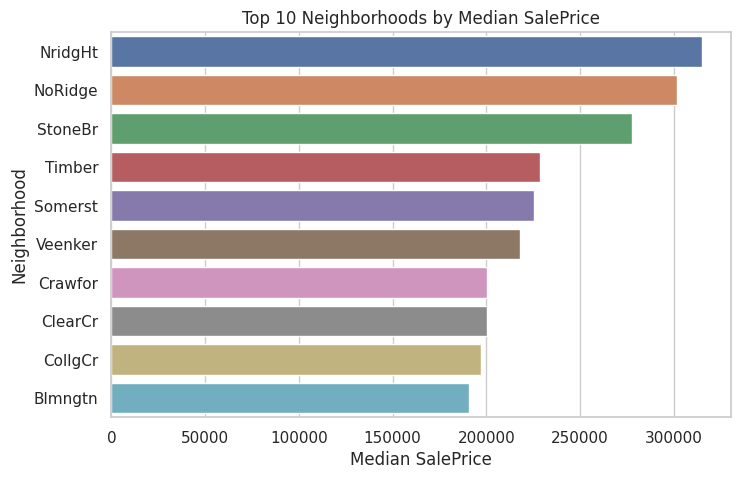

In [15]:
# Plot top 10 neighborhoods by median SalePrice 
top10_neigh = neigh_median.head(10) 
 
sns.barplot(x=top10_neigh.values, y=top10_neigh.index) 
plt.title("Top 10 Neighborhoods by Median SalePrice") 
plt.xlabel("Median SalePrice") 
plt.ylabel("Neighborhood") 
plt.show() 

In [16]:
# ================================== 
# 9. Prepare Data for Modeling 
# ================================== 
 
# Target variable: log1p(SalePrice) 
y = np.log1p(train_df["SalePrice"]) 
 
# Features: all columns except SalePrice 
X = train_df.drop("SalePrice", axis=1) 
 
# Identify numeric and categorical features 
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns 
categorical_features = X.select_dtypes(include=["object"]).columns 
 
print("Number of numeric features:", len(numeric_features)) 
print("Number of categorical features:", len(categorical_features)) 
 
# Preprocessing for numeric data: fill missing values with median 
numeric_transformer = SimpleImputer(strategy="median") 
 
# Preprocessing for categorical data: 
#   - Fill missing values with most frequent category 
#   - One-hot encode categories 
categorical_transformer = Pipeline(steps=[ 
    ("imputer", SimpleImputer(strategy="most_frequent")), 
    ("onehot", OneHotEncoder(handle_unknown="ignore")) 
]) 
 
# Combine both into a ColumnTransformer 
preprocessor = ColumnTransformer( 
    transformers=[ 
        ("num", numeric_transformer, numeric_features), 
        ("cat", categorical_transformer, categorical_features) 
    ] 
) 

Number of numeric features: 37
Number of categorical features: 43


In [17]:
# ========================================== 
# 10. Define Two Base Models + Pipelines 
# ========================================== 
 
# Model 1: Ridge Regression (linear model with L2 regularization) 
ridge_model = Ridge(alpha=10.0, random_state=42) 
 
ridge_pipeline = Pipeline(steps=[ 
    ("preprocessor", preprocessor), 
    ("model", ridge_model) 
]) 
 
# Model 2: Random Forest Regressor (tree-based ensemble model) 
rf_model = RandomForestRegressor( 
    n_estimators=200, 
    max_depth=None, 
    random_state=42, 
    n_jobs=-1 
) 
 
rf_pipeline = Pipeline(steps=[ 
    ("preprocessor", preprocessor), 
    ("model", rf_model) 
]) 

In [18]:
# ===================================== 
# 11. Cross-Validation (Base Models) 
# ===================================== 
 
# Use 5-fold cross-validation 
kf = KFold(n_splits=5, shuffle=True, random_state=42) 
 
# ---- Ridge ---- 
ridge_neg_rmse_scores = cross_val_score( 
    ridge_pipeline, 
    X, 
    y, 
    scoring="neg_root_mean_squared_error",  # negative RMSE 
    cv=kf, 
    n_jobs=-1 
) 
ridge_rmse_scores = -ridge_neg_rmse_scores 
 
print("Ridge RMSE (log scale) per fold:", ridge_rmse_scores) 
print("Ridge Mean RMSE (log):", ridge_rmse_scores.mean()) 
print("Ridge Std RMSE (log):", ridge_rmse_scores.std()) 
 
# ---- Random Forest ---- 
rf_neg_rmse_scores = cross_val_score( 
    rf_pipeline, 
    X, 
    y, 
    scoring="neg_root_mean_squared_error", 
    cv=kf, 
    n_jobs=-1 
) 
rf_rmse_scores = -rf_neg_rmse_scores 
 
print("Random Forest RMSE (log scale) per fold:", rf_rmse_scores) 
print("Random Forest Mean RMSE (log):", rf_rmse_scores.mean()) 
print("Random Forest Std RMSE (log):", rf_rmse_scores.std()) 
 
# Quick comparison of base models 
print("==== Base Model Comparison (Cross-Validation) ====") 
print(f"Ridge        Mean RMSE (log): {ridge_rmse_scores.mean():.5f}") 
print(f"RandomForest Mean RMSE (log): {rf_rmse_scores.mean():.5f}") 

Ridge RMSE (log scale) per fold: [0.14842971 0.1281463  0.24836034 0.1349185  0.1263704 ]
Ridge Mean RMSE (log): 0.15724504919941049
Ridge Std RMSE (log): 0.046212902015006684
Random Forest RMSE (log scale) per fold: [0.14713071 0.12689852 0.17572055 0.14906423 0.12325019]
Random Forest Mean RMSE (log): 0.14441284041758365
Random Forest Std RMSE (log): 0.01878192841082924
==== Base Model Comparison (Cross-Validation) ====
Ridge        Mean RMSE (log): 0.15725
RandomForest Mean RMSE (log): 0.14441


## 12. Hyperparameter Tuning (GridSearchCV) 
 
We now try to improve both models by tuning their hyperparameters: 
 
- For **Ridge**, we tune `alpha`. 
- For **Random Forest**, we tune: 
  - `n_estimators` (number of trees) 
  - `max_depth` (max depth of each tree) 
  - `min_samples_leaf` (minimum samples in a leaf) 
 
We use `GridSearchCV` with the same metric (RMSE on the log scale). 

In [19]:
# ================================== 
# 12.1 Tune Ridge Regression 
# ================================== 
 
# Grid of alpha values to try 
ridge_param_grid = { 
    "model__alpha": [0.1, 1.0, 3.0, 10.0, 30.0, 100.0] 
} 
 
ridge_grid_search = GridSearchCV( 
    estimator=ridge_pipeline, 
    param_grid=ridge_param_grid, 
    scoring="neg_root_mean_squared_error", 
    cv=5, 
    n_jobs=-1, 
    verbose=1 
) 
 
# This will run cross-validation for each alpha value 
ridge_grid_search.fit(X, y) 
 
# Best Ridge result 
best_ridge_rmse = -ridge_grid_search.best_score_  # convert from negative 
best_ridge_params = ridge_grid_search.best_params_ 
 
print("Best Ridge RMSE (log):", best_ridge_rmse) 
print("Best Ridge parameters:", best_ridge_params) 

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Ridge RMSE (log): 0.1518082096323307
Best Ridge parameters: {'model__alpha': 30.0}


In [20]:
# ======================================= 
# 12.2 Tune Random Forest Regressor 
# ======================================= 
 
rf_param_grid = { 
    "model__n_estimators": [100, 200, 400], 
    "model__max_depth": [None, 10, 20], 
    "model__min_samples_leaf": [1, 2, 5] 
} 
 
rf_grid_search = GridSearchCV( 
    estimator=rf_pipeline, 
    param_grid=rf_param_grid, 
    scoring="neg_root_mean_squared_error", 
    cv=5, 
    n_jobs=-1, 
    verbose=1 
) 
 
# This may take a bit longer than Ridge 
rf_grid_search.fit(X, y) 
 
# Best Random Forest result 
best_rf_rmse = -rf_grid_search.best_score_ 
best_rf_params = rf_grid_search.best_params_ 
 
print("Best Random Forest RMSE (log):", best_rf_rmse) 
print("Best Random Forest parameters:", best_rf_params) 
 
# Tuned model comparison 
print("==== Tuned Model Comparison (Cross-Validation) ====") 
print(f"Tuned Ridge        Best RMSE (log): {best_ridge_rmse:.5f}") 
print(f"Tuned RandomForest Best RMSE (log): {best_rf_rmse:.5f}") 

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Random Forest RMSE (log): 0.14235775336631984
Best Random Forest parameters: {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__n_estimators': 200}
==== Tuned Model Comparison (Cross-Validation) ====
Tuned Ridge        Best RMSE (log): 0.15181
Tuned RandomForest Best RMSE (log): 0.14236


In [21]:
# =========================================== 
# 13. Train Tuned Models on Full Training Data 
# =========================================== 
 
# Get the best (tuned) pipelines from GridSearchCV 
best_ridge_pipeline = ridge_grid_search.best_estimator_ 
best_rf_pipeline = rf_grid_search.best_estimator_ 
 
# Fit both on all training data 
best_ridge_pipeline.fit(X, y) 
best_rf_pipeline.fit(X, y) 
 
print("Finished training tuned Ridge and Random Forest models on full data.") 

Finished training tuned Ridge and Random Forest models on full data.


In [22]:
# ==================================== 
# 14. Make Predictions on Test Data 
# ==================================== 
 
test_X = test_df.copy() 
 
# Tuned Ridge predictions 
test_pred_log_ridge = best_ridge_pipeline.predict(test_X) 
test_pred_ridge = np.expm1(test_pred_log_ridge)  # convert back from log1p 
 
# Tuned Random Forest predictions 
test_pred_log_rf = best_rf_pipeline.predict(test_X) 
test_pred_rf = np.expm1(test_pred_log_rf) 

In [23]:
# ==================================== 
# 15. Create Submission Files 
# ==================================== 
 
# Submission for tuned Ridge model 
submission_ridge = pd.DataFrame({ 
    "Id": test_df["Id"], 
    "SalePrice": test_pred_ridge 
}) 
 
# Submission for tuned Random Forest model 
submission_rf = pd.DataFrame({ 
    "Id": test_df["Id"], 
    "SalePrice": test_pred_rf 
}) 
 
# Save to CSV (ready to upload to Kaggle) 
submission_ridge.to_csv("submission_ridge_tuned.csv", index=False) 
submission_rf.to_csv("submission_rf_tuned.csv", index=False) 
 
print("Saved submission_ridge_tuned.csv and submission_rf_tuned.csv") 

Saved submission_ridge_tuned.csv and submission_rf_tuned.csv


## 16. Summary 
 
In this notebook we: 
 
1. **Loaded** the train and test datasets. 
2. Performed **exploratory data analysis (EDA)**: 
   - Looked at distributions of `SalePrice` and `log1p(SalePrice)`. 
   - Explored relationships with important features like `GrLivArea` and `OverallQual`. 
   - Inspected missing values and correlations. 
   - Examined median `SalePrice` by `Neighborhood`. 
3. **Prepared the data**: 
   - Split into features `X` and target `y`. 
   - Applied `log1p` to `SalePrice`. 
   - Handled missing values (median for numeric, most frequent for categorical). 
   - One-hot encoded categorical variables using a `ColumnTransformer`. 
4. Built **two models**: 
   - **Ridge Regression** (linear model with L2 regularization). 
   - **Random Forest Regressor** (tree-based ensemble). 
5. Evaluated both models using **5-fold cross-validation** and RMSE on the log scale. 
6. Performed **hyperparameter tuning** with `GridSearchCV`: 
   - Tuned `alpha` for Ridge. 
   - Tuned `n_estimators`, `max_depth`, and `min_samples_leaf` for Random Forest. 
7. Compared tuned models and then **trained the best pipelines** on all training data. 
8. Generated predictions for the test set and created **two submission files**: 
   - `submission_ridge_tuned.csv` 
   - `submission_rf_tuned.csv` 
 
These files can be uploaded directly to Kaggle.   
From here, you can improve the project by: 
- Trying more advanced models (XGBoost, LightGBM, etc.). 
- Doing more feature engineering and domain-specific analysis. 
- Using more detailed hyperparameter tuning. 
 
But as it stands, this notebook is a complete, beginner-friendly end-to-end solution for the competition. 